In [1]:
import generate_masterdf as gm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from generate_plots import subject_wise_error_plot, quick_visualization, distribution_plots
from helpers import variance_error_summary
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)

We have 9 subjects so far: ['sub01', 'sub03', 'sub06', 'sub08', 'sub12', 'sub13', 'sub14', 'sub15', 'sub16']

Loading existing dataframe! If this is not desired, delete the current mater_df.csv


In [2]:
df = gm.master_df
df = variance_error_summary(df)
print('Dataframe description')
df.info()

Dataframe description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subjID                    10800 non-null  int64  
 1   day                       10800 non-null  int64  
 2   tnum                      10800 non-null  int64  
 3   rnum                      10800 non-null  int64  
 4   istms                     10800 non-null  int64  
 5   ispro                     10800 non-null  int64  
 6   instimVF                  10800 non-null  int64  
 7   breakfix                  10800 non-null  int64  
 8   no_prim_sacc              10800 non-null  int64  
 9   small_sacc                10800 non-null  int64  
 10  large_error               10800 non-null  int64  
 11  rejtrials                 10800 non-null  int64  
 12  TarX                      10800 non-null  float64
 13  TarY                      10800 non-nul

In [ ]:
df.describe()
df.describe(include=object)

In [3]:
n_rows_original = len(df)
# Filter out entries with 'rejtrials' == 1
df_filtered = df[(df['rejtrials'] != 1)].copy()
df_filtered = df_filtered.dropna()
n_rows_filtered = len(df_filtered)
print(f"Original = {n_rows_original}, after filtering = {n_rows_filtered} trials.")
print()
print('Dataframe description after filtering')
df_filtered.info()

Original = 10800, after filtering = 9755 trials.

Dataframe description after filtering
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9755 entries, 0 to 10798
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subjID                    9755 non-null   int64  
 1   day                       9755 non-null   int64  
 2   tnum                      9755 non-null   int64  
 3   rnum                      9755 non-null   int64  
 4   istms                     9755 non-null   int64  
 5   ispro                     9755 non-null   int64  
 6   instimVF                  9755 non-null   int64  
 7   breakfix                  9755 non-null   int64  
 8   no_prim_sacc              9755 non-null   int64  
 9   small_sacc                9755 non-null   int64  
 10  large_error               9755 non-null   int64  
 11  rejtrials                 9755 non-null   int64  
 12  TarX                      975

In [4]:
# Summary across conditions for subjects
table_summary = pd.pivot_table(df, values = 'fsacc_err', index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.sum(~pd.isnull(x)))
table_summary

TMS_condition No TMS      TMS intoVF      TMS outVF     
ispro              0    1          0    1         0    1
subjID                                                  
1                200  199        199  199       197  200
3                200  197        200  200       200  200
6                199  197        193  188       199  198
8                157  139        149  145       142  134
12               193  187        195  194       197  193
13               197  194        189  190       192  196
14               197  199        199  199       200  198
15               199  199        197  197       195  196
16               179  177        195  190       196  186

In [5]:
raw_error_summary = pd.pivot_table(df_filtered, values = ['fsacc_err', 'fsacc_theta_err', 'fsacc_radius_err'], index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.nanmean(np.abs(x)))
raw_error_summary

fsacc_err                                               \
TMS_condition    No TMS         TMS intoVF         TMS outVF           
ispro                 0       1          0       1         0       1   
subjID                                                                 
1                1.1042  0.9123     1.3781  1.1546    1.0687  0.8052   
3                1.3032  0.9492     1.1728  1.0812    1.1832  1.1716   
6                1.2867  1.0363     1.3183  1.1153    1.3234  1.1279   
8                2.2903  2.1058     2.4002  1.8627    2.3583  2.2499   
12               1.6343  1.3569     1.3644  1.2547    1.6734  1.3404   
13               1.1910  1.1490     1.6434  1.5591    1.1820  1.2114   
14               1.6884  1.1808     1.6603  1.1045    1.4112  1.0261   
15               1.4685  1.4462     1.8543  1.4355    1.3501  1.2398   
16               2.1902  2.1225     2.4847  1.9935    2.3056  2.1348   

              fsacc_radius_err                                               \
TMS_condition           No TMS         TMS intoVF         TMS outVF           
ispro                        0       1          0       1         0       1   
subjID                                                                        
1                       0.8370  0.7575     1.0752  0.9682    0.8098  0.6215   
3                       0.8304  0.5726     0.7587  0.6505    0.7531  0.6668   
6                       1.0795  0.9162     1.1641  0.9774    1.0246  0.9582   
8                       2.0378  1.5584     2.1112  1.2452    2.0532  1.6967   
12                      1.2341  0.9665     1.0408  1.0373    1.1684  0.9037   
13                      0.7882  0.8172     1.0543  0.9973    0.8104  0.7608   
14                      1.2015  0.8363     1.0717  0.7990    0.9398  0.7385   
15                      1.1466  1.2002     1.5122  1.0993    1.1434  1.0357   
16                      1.5606  1.6781     1.8374  1.4788    1.5220  1.5676   

              fsacc_theta_err                                               
TMS_condition          No TMS         TMS intoVF         TMS outVF          
ispro                       0       1          0       1         0       1  
subjID                                                                      
1                      0.1638  0.1523     0.0466  0.0325    0.4449  0.2469  
3                      0.1381  0.0986     0.1658  0.2926    0.0448  0.0498  
6                      0.0394  0.0265     0.0353  0.0352    0.0466  0.0340  
8                      0.0726  0.0871     0.0621  0.0812    0.0665  0.1087  
12                     0.1219  0.1709     0.1012  0.0839    0.2733  0.3192  
13                     0.1295  0.1744     0.1951  0.1623    0.1609  0.3171  
14                     0.0727  0.0490     0.0779  0.0439    0.0627  0.0407  
15                     0.0451  0.0368     0.0563  0.0453    0.0313  0.0295  
16                     0.1255  0.1081     0.1109  0.0826    0.1704  0.1125

In [6]:
error_summary = pd.pivot_table(df_filtered, values = ['fsacc_theta_rot_normed', 'fsacc_theta_rot'], index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.nanmean(np.abs(x)))
error_summary

fsacc_theta_rot                                               \
TMS_condition          No TMS         TMS intoVF         TMS outVF           
ispro                       0       1          0       1         0       1   
subjID                                                                       
1                      0.0379  0.0269     0.0466  0.0325    0.0376  0.0265   
3                      0.0498  0.0390     0.0442  0.0440    0.0448  0.0498   
6                      0.0394  0.0265     0.0353  0.0352    0.0466  0.0340   
8                      0.0701  0.0871     0.0621  0.0812    0.0665  0.1087   
12                     0.1219  0.1345     0.1012  0.0839    0.1434  0.1260   
13                     0.1295  0.1188     0.1953  0.1623    0.1274  0.1445   
14                     0.0727  0.0490     0.0779  0.0439    0.0627  0.0407   
15                     0.0451  0.0368     0.0563  0.0453    0.0313  0.0295   
16                     0.0873  0.0691     0.1036  0.0826    0.1016  0.0747   

              fsacc_theta_rot_normed                                       \
TMS_condition                 No TMS         TMS intoVF         TMS outVF   
ispro                              0       1          0       1         0   
subjID                                                                      
1                             0.0935  0.0664     0.1150  0.0802    0.0928   
3                             0.0520  0.0407     0.0461  0.0459    0.0468   
6                             0.2202  0.1480     0.1975  0.1970    0.2606   
8                             0.3782  0.4694     0.3349  0.4380    0.3585   
12                            0.1652  0.1823     0.1371  0.1137    0.1943   
13                            0.1009  0.0926     0.1521  0.1264    0.0992   
14                            0.2289  0.1542     0.2453  0.1382    0.1972   
15                            0.6552  0.5345     0.8179  0.6581    0.4553   
16                            0.0579  0.0458     0.0687  0.0548    0.0673   

                       
TMS_condition          
ispro               1  
subjID                 
1              0.0655  
3              0.0520  
6              0.1903  
8              0.5859  
12             0.1707  
13             0.1126  
14             0.1280  
15             0.4287  
16             0.0495

In [ ]:
df_filtered.describe()
df_filtered.describe(include=object)

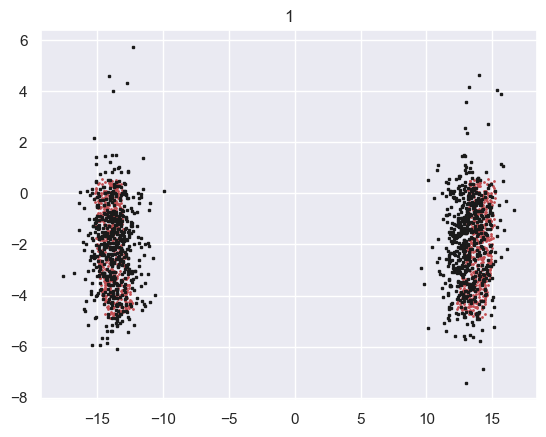

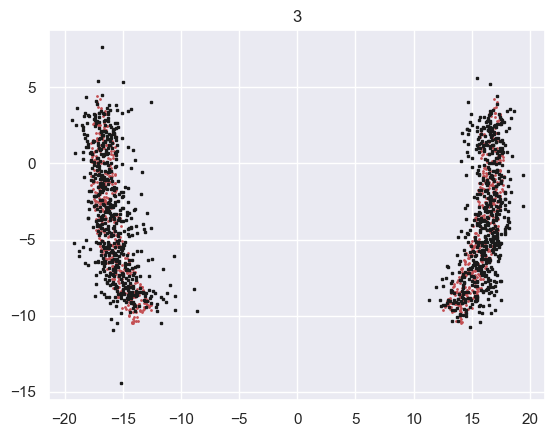

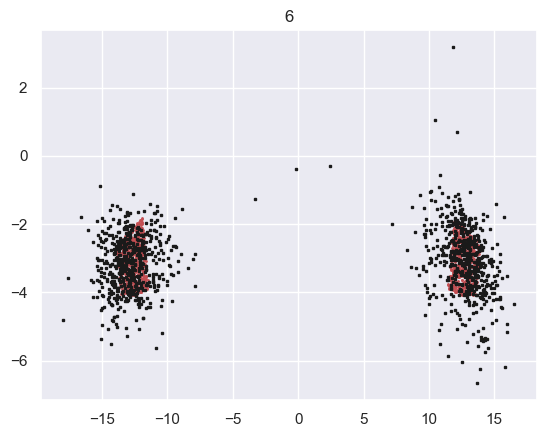

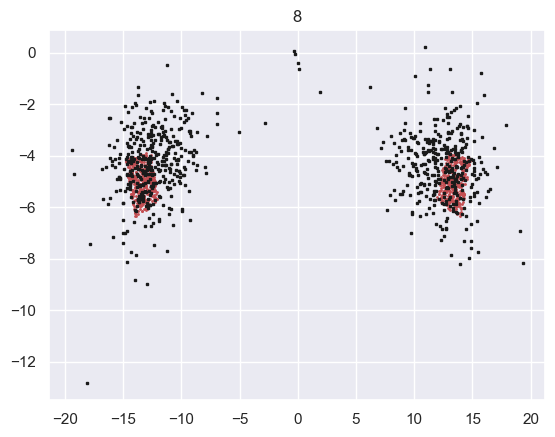

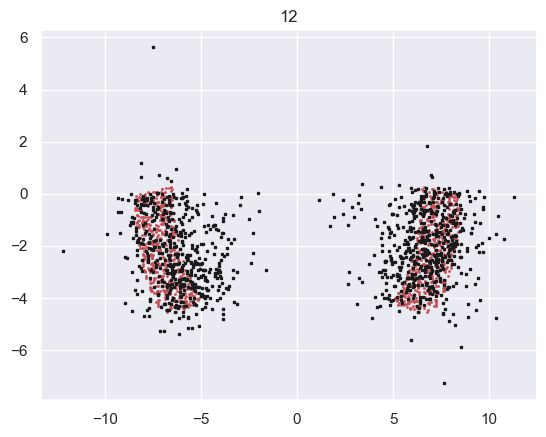

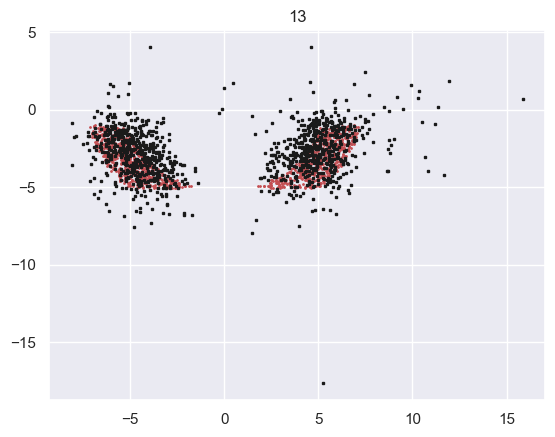

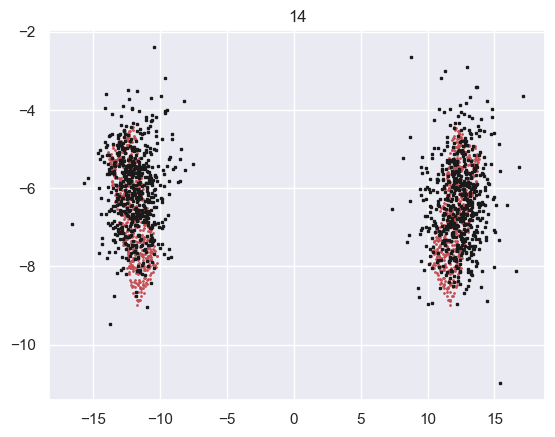

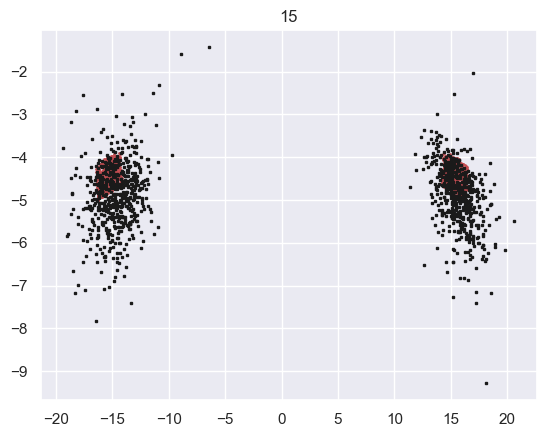

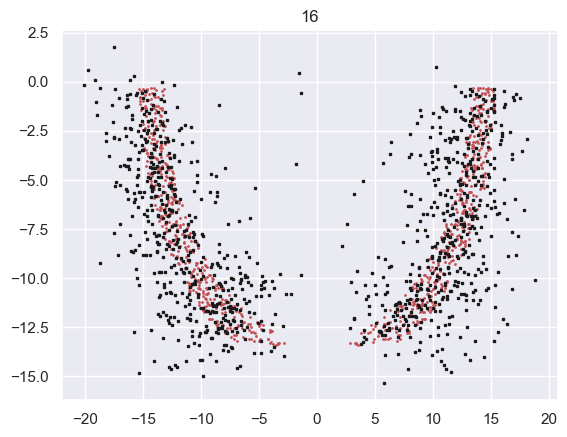

In [7]:
subjIDs = df_filtered['subjID'].unique()
#df_filtered = df_filtered[df_filtered['instimVF'] == 0 ]
for ii in range(len(subjIDs)):
    plt.figure()
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarX'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarY'], 'r.', markersize = 2)
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccX'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccY'], 'ks', markersize = 2)
    plt.title(str(subjIDs[ii]))

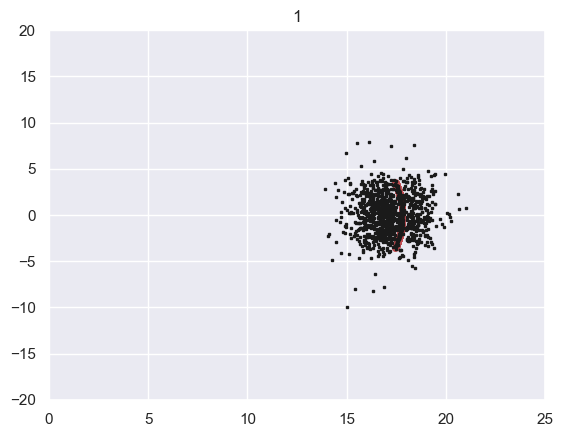

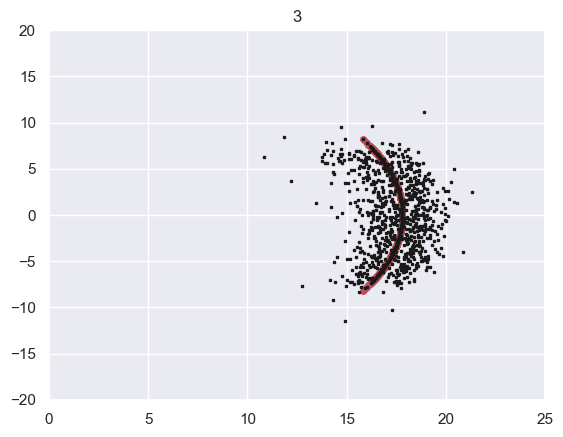

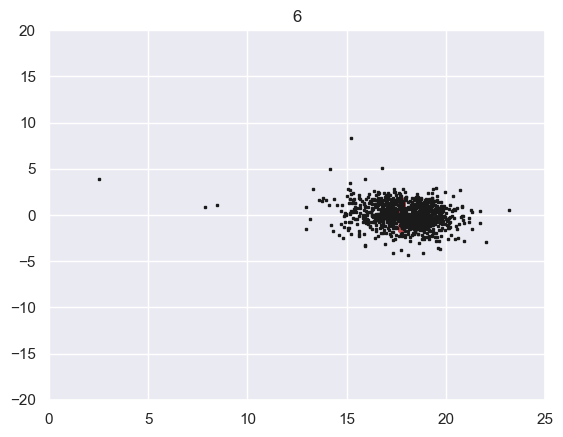

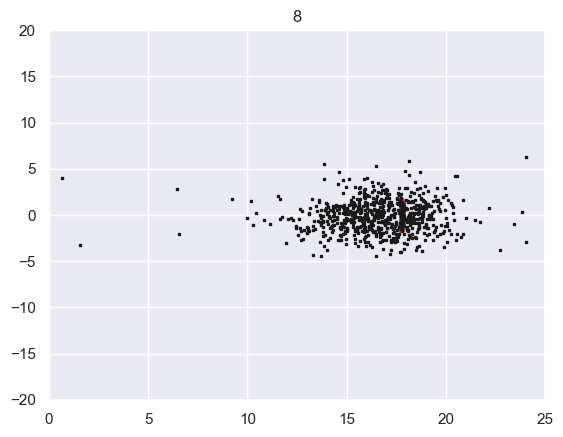

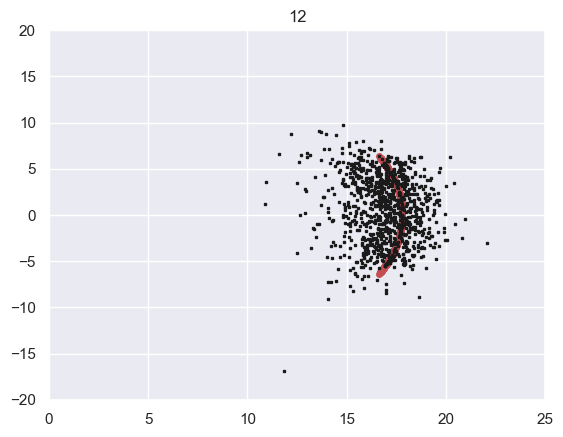

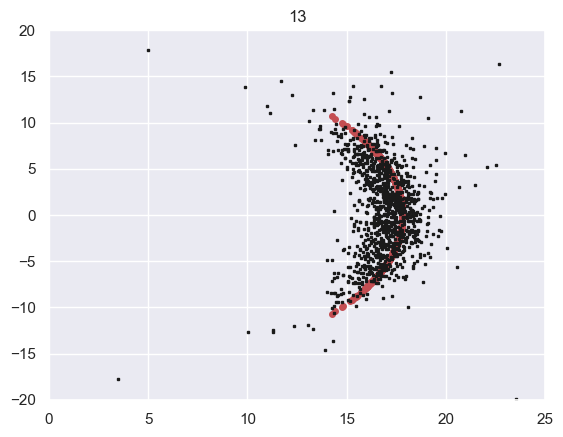

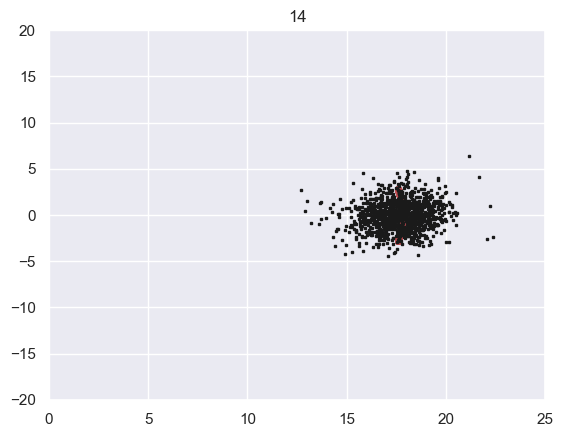

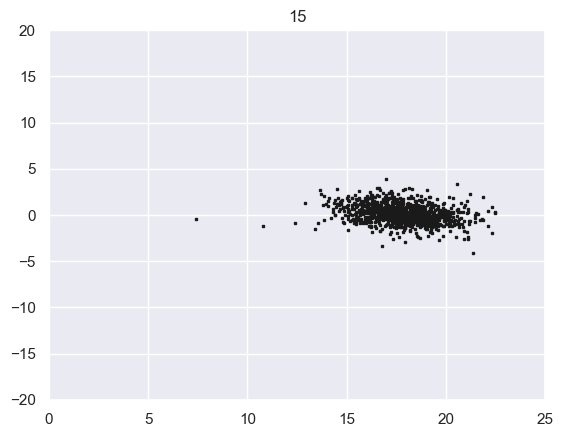

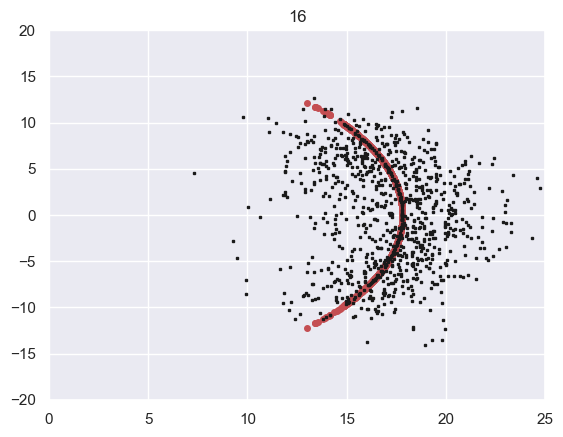

In [8]:
subjIDs = df_filtered['subjID'].unique()
#df_filtered = df_filtered[(df_filtered['TarTheta'] > -np.pi/2) & (df_filtered['TarTheta'] < np.pi/2) ]
for ii in range(len(subjIDs)):
    plt.figure()
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarX_rotated_only'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarY_rotated_only'], 'ro', markersize = 4)
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccX_rotated_only'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccY_rotated_only'], 'ks', markersize = 2)
    plt.xlim([0, 25])
    plt.ylim([-20, 20])
    plt.title(str(subjIDs[ii]))

In [ ]:
table_summary_hh = pd.pivot_table(df, values = 'TarTheta_rotated_only', index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: (np.max(x) - np.min(x)) * (180/np.pi))
table_summary_hh

In [ ]:
#subject_wise_error_plot(df_filtered, 'fsacc_theta_err')
#subject_wise_error_plot(df_filtered, 'corrected_theta_err')
#subject_wise_error_plot(df_filtered, 'isacc_radius_err')
#subject_wise_error_plot(df_filtered, 'fsacc_radius_err')

#subject_wise_error_plot(df_filtered, 'corrected_radius_err')
subjIDs = df_filtered['subjID'].unique()
#df_filtered['fsacc_theta_err'] = df_filtered['fsacc_theta_err'].abs()
for ii in range(len(subjIDs)):
    subject_wise_error_plot(df_filtered[df_filtered['subjID'] == subjIDs[ii]], 'fsacc_err')
    #subject_wise_error_plot(df_filtered[df_filtered['subjID'] == subjIDs[ii]], 'fsacc_err')
#df_filtered['fsacc_theta_err'] = np.abs(df_filtered['fsacc_theta_err'])
subject_wise_error_plot(df_filtered, 'fsacc_err')
#subject_wise_error_plot(df_filtered, 'isacc_peakvel')
#subject_wise_error_plot(df_filtered, 'fsacc_peakvel')

In [ ]:

subjIDs = df['subjID'].unique()
max_ax = 25
for ss in range(len(subjIDs)):
    subj_df =  df[df['subjID']==subjIDs[ss]]
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
    plt.suptitle(subjIDs[ss])
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro')
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro')
    
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro')
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro')
    
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro')
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro')
    

    axes[0, 0].set_xlim([-max_ax, max_ax])
    axes[0, 0].set_ylim([-max_ax, max_ax])
    axes[0, 1].set_xlim([-max_ax, max_ax])
    axes[0, 1].set_ylim([-max_ax, max_ax])
    axes[1, 0].set_xlim([-max_ax, max_ax])
    axes[1, 0].set_ylim([-max_ax, max_ax])
    axes[1, 1].set_xlim([-max_ax, max_ax])
    axes[1, 1].set_ylim([-max_ax, max_ax])
    axes[2, 0].set_xlim([-max_ax, max_ax])
    axes[2, 0].set_ylim([-max_ax, max_ax])
    axes[2, 1].set_xlim([-max_ax, max_ax])
    axes[2, 1].set_ylim([-max_ax, max_ax])

    axes[0, 0].set_box_aspect(1)
    axes[0, 1].set_box_aspect(1)
    axes[1, 0].set_box_aspect(1)
    axes[1, 1].set_box_aspect(1)
    axes[2, 0].set_box_aspect(1)
    axes[2, 1].set_box_aspect(1)

    axes[0, 0].set_title('No TMS & pro')
    axes[0, 1].set_title('No TMS & anti')
    axes[1, 0].set_title('TMS intoVF & pro')
    axes[1, 1].set_title('TMS intoVF & anti')
    axes[2, 0].set_title('TMS outVF & pro')
    axes[2, 1].set_title('TMS outVF & anti')
    plt.show()
    

In [ ]:

subjIDs = df['subjID'].unique()
max_ax = 25
nbins = 70
for ss in range(len(subjIDs)):
    subj_df =  df[(df['subjID']==subjIDs[ss]) & (df['rejtrials']!=1)]
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
    plt.suptitle(subjIDs[ss])
    axes[0, 0].hist2d(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[0, 1].hist2d(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[1, 0].hist2d(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[1, 1].hist2d(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[2, 0].hist2d(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[2, 1].hist2d(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    

    axes[0, 0].set_xlim([0, max_ax])
    axes[0, 0].set_ylim([-max_ax, max_ax])
    axes[0, 1].set_xlim([0, max_ax])
    axes[0, 1].set_ylim([-max_ax, max_ax])
    axes[1, 0].set_xlim([0, max_ax])
    axes[1, 0].set_ylim([-max_ax, max_ax])
    axes[1, 1].set_xlim([0, max_ax])
    axes[1, 1].set_ylim([-max_ax, max_ax])
    axes[2, 0].set_xlim([0, max_ax])
    axes[2, 0].set_ylim([-max_ax, max_ax])
    axes[2, 1].set_xlim([0, max_ax])
    axes[2, 1].set_ylim([-max_ax, max_ax])

    axes[0, 0].set_box_aspect(1)
    axes[0, 1].set_box_aspect(1)
    axes[1, 0].set_box_aspect(1)
    axes[1, 1].set_box_aspect(1)
    axes[2, 0].set_box_aspect(1)
    axes[2, 1].set_box_aspect(1)

    axes[0, 0].set_title('No TMS & pro')
    axes[0, 1].set_title('No TMS & anti')
    axes[1, 0].set_title('TMS intoVF & pro')
    axes[1, 1].set_title('TMS intoVF & anti')
    axes[2, 0].set_title('TMS outVF & pro')
    axes[2, 1].set_title('TMS outVF & anti')
    plt.show()

In [ ]:
quick_visualization(df_filtered)

In [ ]:
distribution_plots(df_filtered)